In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import networkx as nx
import community as community_louvain
from collections import Counter, defaultdict
import netwulf as nw

https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?resource=download&fbclid=IwZXh0bgNhZW0CMTEAAR5jxk4FClm9GBFvCklV4Ga5SRwON3ajfqLdOMjFqN1uereEEduffCtjEbkjJg_aem_YUf8t7fIjwbCWiHS_vrVcg

In [2]:
artists_us = pd.read_csv("american_artists.csv", index_col=0)
american_artists = (artists_us.index).tolist()
#american_artists = artists_location[artists_location["country_mb"] == "United States"]["artist_mb"].tolist()

In [3]:
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')

nodes_df = nodes_df[nodes_df["name"].isin(american_artists)]

nodes_df['genres'] = nodes_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])


In [4]:
nodes_df

,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"[nordic house, russelater]",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"[christlicher rap, german hip hop]","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
15,3xs0LEzcPXtgNfMNcHzLIP,Rockwell,40344.0,58,[],"['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (..."
20,2NUz5P42WqkxilbI8ocN76,Vybz Kartel,1026598.0,63,"[dancehall, jamaican dancehall, reggae fusion]","['cr (3)', 'pa (1)']"
22,4Lm0pUvmisUHMdoky5ch2I,Apocalyptica,864846.0,60,"[alternative metal, bow pop, cello, finnish me...",['fi (2)']
...,...,...,...,...,...,...
156038,7p5J8SfKU9Rulp7tcA53G8,Jose Merce,182186.0,51,"[cante flamenco, flamenco, nuevo flamenco, rumba]",NaN
156119,3gJ0f9ov2Vjrbo9RnFFH76,Endor,267.0,2,[scottish indie folk],NaN
156199,7mKmqnXqn1WoEFljKyvAHR,2T FLOW,20.0,29,[],NaN
156220,6kT18gnkVrCz8xJQcrib7L,Bhaskar,230894.0,60,"[brazilian bass, brazilian edm, brazilian house]",NaN


In [5]:
def split_artists_by_genre(nodes_df, genre_names, exclusive=False):    
    nodes_df = nodes_df.copy()

    filtered_dfs = []

    for genre in genre_names:
        if exclusive:
            other_genres = [g for g in genre_names if g != genre]
            
            df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres) and all(other not in ' '.join(genres) for other in other_genres)
                )
            ].copy()
        else:
             df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres)
                )
            ].copy()
        
        filtered_dfs.append(df)

    return filtered_dfs

def get_Graph_with_names(nodes_df, edges_df, verbose=True):
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])

    # Build ID to name map
    id_to_name = dict(zip(nodes_df['spotify_id'], nodes_df['name']))
    allowed_ids = set(id_to_name.keys())

    # Create graph with artist names as nodes
    G = nx.Graph()

    for _, row in nodes_df.iterrows():
        artist_name = row['name']
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres']
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []

        G.add_node(artist_name, followers=followers, popularity=popularity,
                   genres=genres, chart_hits=chart_hits)

    for _, row in edges_df.iterrows():
        id_0, id_1 = row['id_0'], row['id_1']
        if id_0 in allowed_ids and id_1 in allowed_ids:
            name_0 = id_to_name.get(id_0)
            name_1 = id_to_name.get(id_1)
            if name_0 and name_1:
                G.add_edge(name_0, name_1)

    if verbose:
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Network density: {nx.density(G)}")

    return G

def get_n_largest_component(G, n):
    return sorted(nx.connected_components(G), key=len, reverse=True)[n]

def apply_louvain(G, verbose=True):
    partition = community_louvain.best_partition(G)

    nx.set_node_attributes(G, partition, 'community')
    
    if verbose:
        community_sizes = Counter(partition.values())
        sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
        for community_id, size in sorted_communities:
            print(f"Community {community_id}: {size} nodes")
    
    communities = defaultdict(list)
    for node, community_id in partition.items():
        communities[community_id].append(node)
    
    sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    return sorted_communities
        
def get_community_subgraph(G, community_id):
    nodes_in_community = [n for n, attr in G.nodes(data=True) if attr.get('community') == community_id]
    
    subgraph = G.subgraph(nodes_in_community).copy()
    
    return subgraph

def get_combined_louvain_splitted_graph(G):
    _G = G.copy()
    partition = community_louvain.best_partition(_G)
    nx.set_node_attributes(_G, partition, 'community')

    combined_G = nx.Graph()
    
    combined_G.add_nodes_from(_G.nodes(data=True))

    for u, v in _G.edges():
        if partition[u] == partition[v]:
            combined_G.add_edge(u, v, **_G[u][v])

    return combined_G

def print_top_collaborators(G, n):
    top_collaborators = sorted(G.degree, key=lambda x: x[1], reverse=True)[:n]

    print(f"Top {n} artists with the most collaborations:")
    for rank, (artist, degree) in enumerate(top_collaborators, start=1):
        print(f"{rank}. {artist} — {degree} collaborations")


In [6]:
pop_df, rap_df = split_artists_by_genre(nodes_df, ["pop", "rap"])

len(pop_df), len(rap_df)

(4474, 1765)

In [7]:
G_pop = get_Graph_with_names(pop_df, edges_df)
G_rap = get_Graph_with_names(rap_df, edges_df)

Number of nodes: 4423
Number of edges: 17847
Network density: 0.0018249860188707665
Number of nodes: 1744
Number of edges: 11988
Network density: 0.007887381768226247


In [8]:
print_top_collaborators(G_rap, 10)

Top 10 artists with the most collaborations:
1. Ty Dolla $ign — 133 collaborations
2. Gucci Mane — 129 collaborations
3. French Montana — 126 collaborations
4. Future — 117 collaborations
5. Farruko — 115 collaborations
6. Lil Wayne — 113 collaborations
7. Snoop Dogg — 111 collaborations
8. 2 Chainz — 110 collaborations
9. Wiz Khalifa — 110 collaborations
10. Young Thug — 104 collaborations


In [9]:
G_rap_splittet = get_combined_louvain_splitted_graph(G_rap)

In [26]:
communities = apply_louvain(G_rap)
largest_community_id = communities[0][0]

G_largest_rap_community = get_community_subgraph(G_rap, largest_community_id)
G_largest_rap_community_splitted = get_combined_louvain_splitted_graph(G_largest_rap_community)

Community 2: 462 nodes
Community 5: 264 nodes
Community 23: 146 nodes
Community 14: 131 nodes
Community 11: 126 nodes
Community 9: 99 nodes
Community 8: 91 nodes
Community 16: 65 nodes
Community 7: 60 nodes
Community 67: 27 nodes
Community 21: 27 nodes
Community 36: 24 nodes
Community 4: 18 nodes
Community 56: 17 nodes
Community 12: 5 nodes
Community 54: 5 nodes
Community 83: 4 nodes
Community 116: 4 nodes
Community 30: 3 nodes
Community 42: 3 nodes
Community 110: 3 nodes
Community 146: 3 nodes
Community 47: 2 nodes
Community 89: 2 nodes
Community 90: 2 nodes
Community 109: 2 nodes
Community 120: 2 nodes
Community 3: 1 nodes
Community 6: 1 nodes
Community 10: 1 nodes
Community 13: 1 nodes
Community 15: 1 nodes
Community 17: 1 nodes
Community 18: 1 nodes
Community 20: 1 nodes
Community 24: 1 nodes
Community 25: 1 nodes
Community 26: 1 nodes
Community 27: 1 nodes
Community 28: 1 nodes
Community 29: 1 nodes
Community 31: 1 nodes
Community 32: 1 nodes
Community 33: 1 nodes
Community 35: 1 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


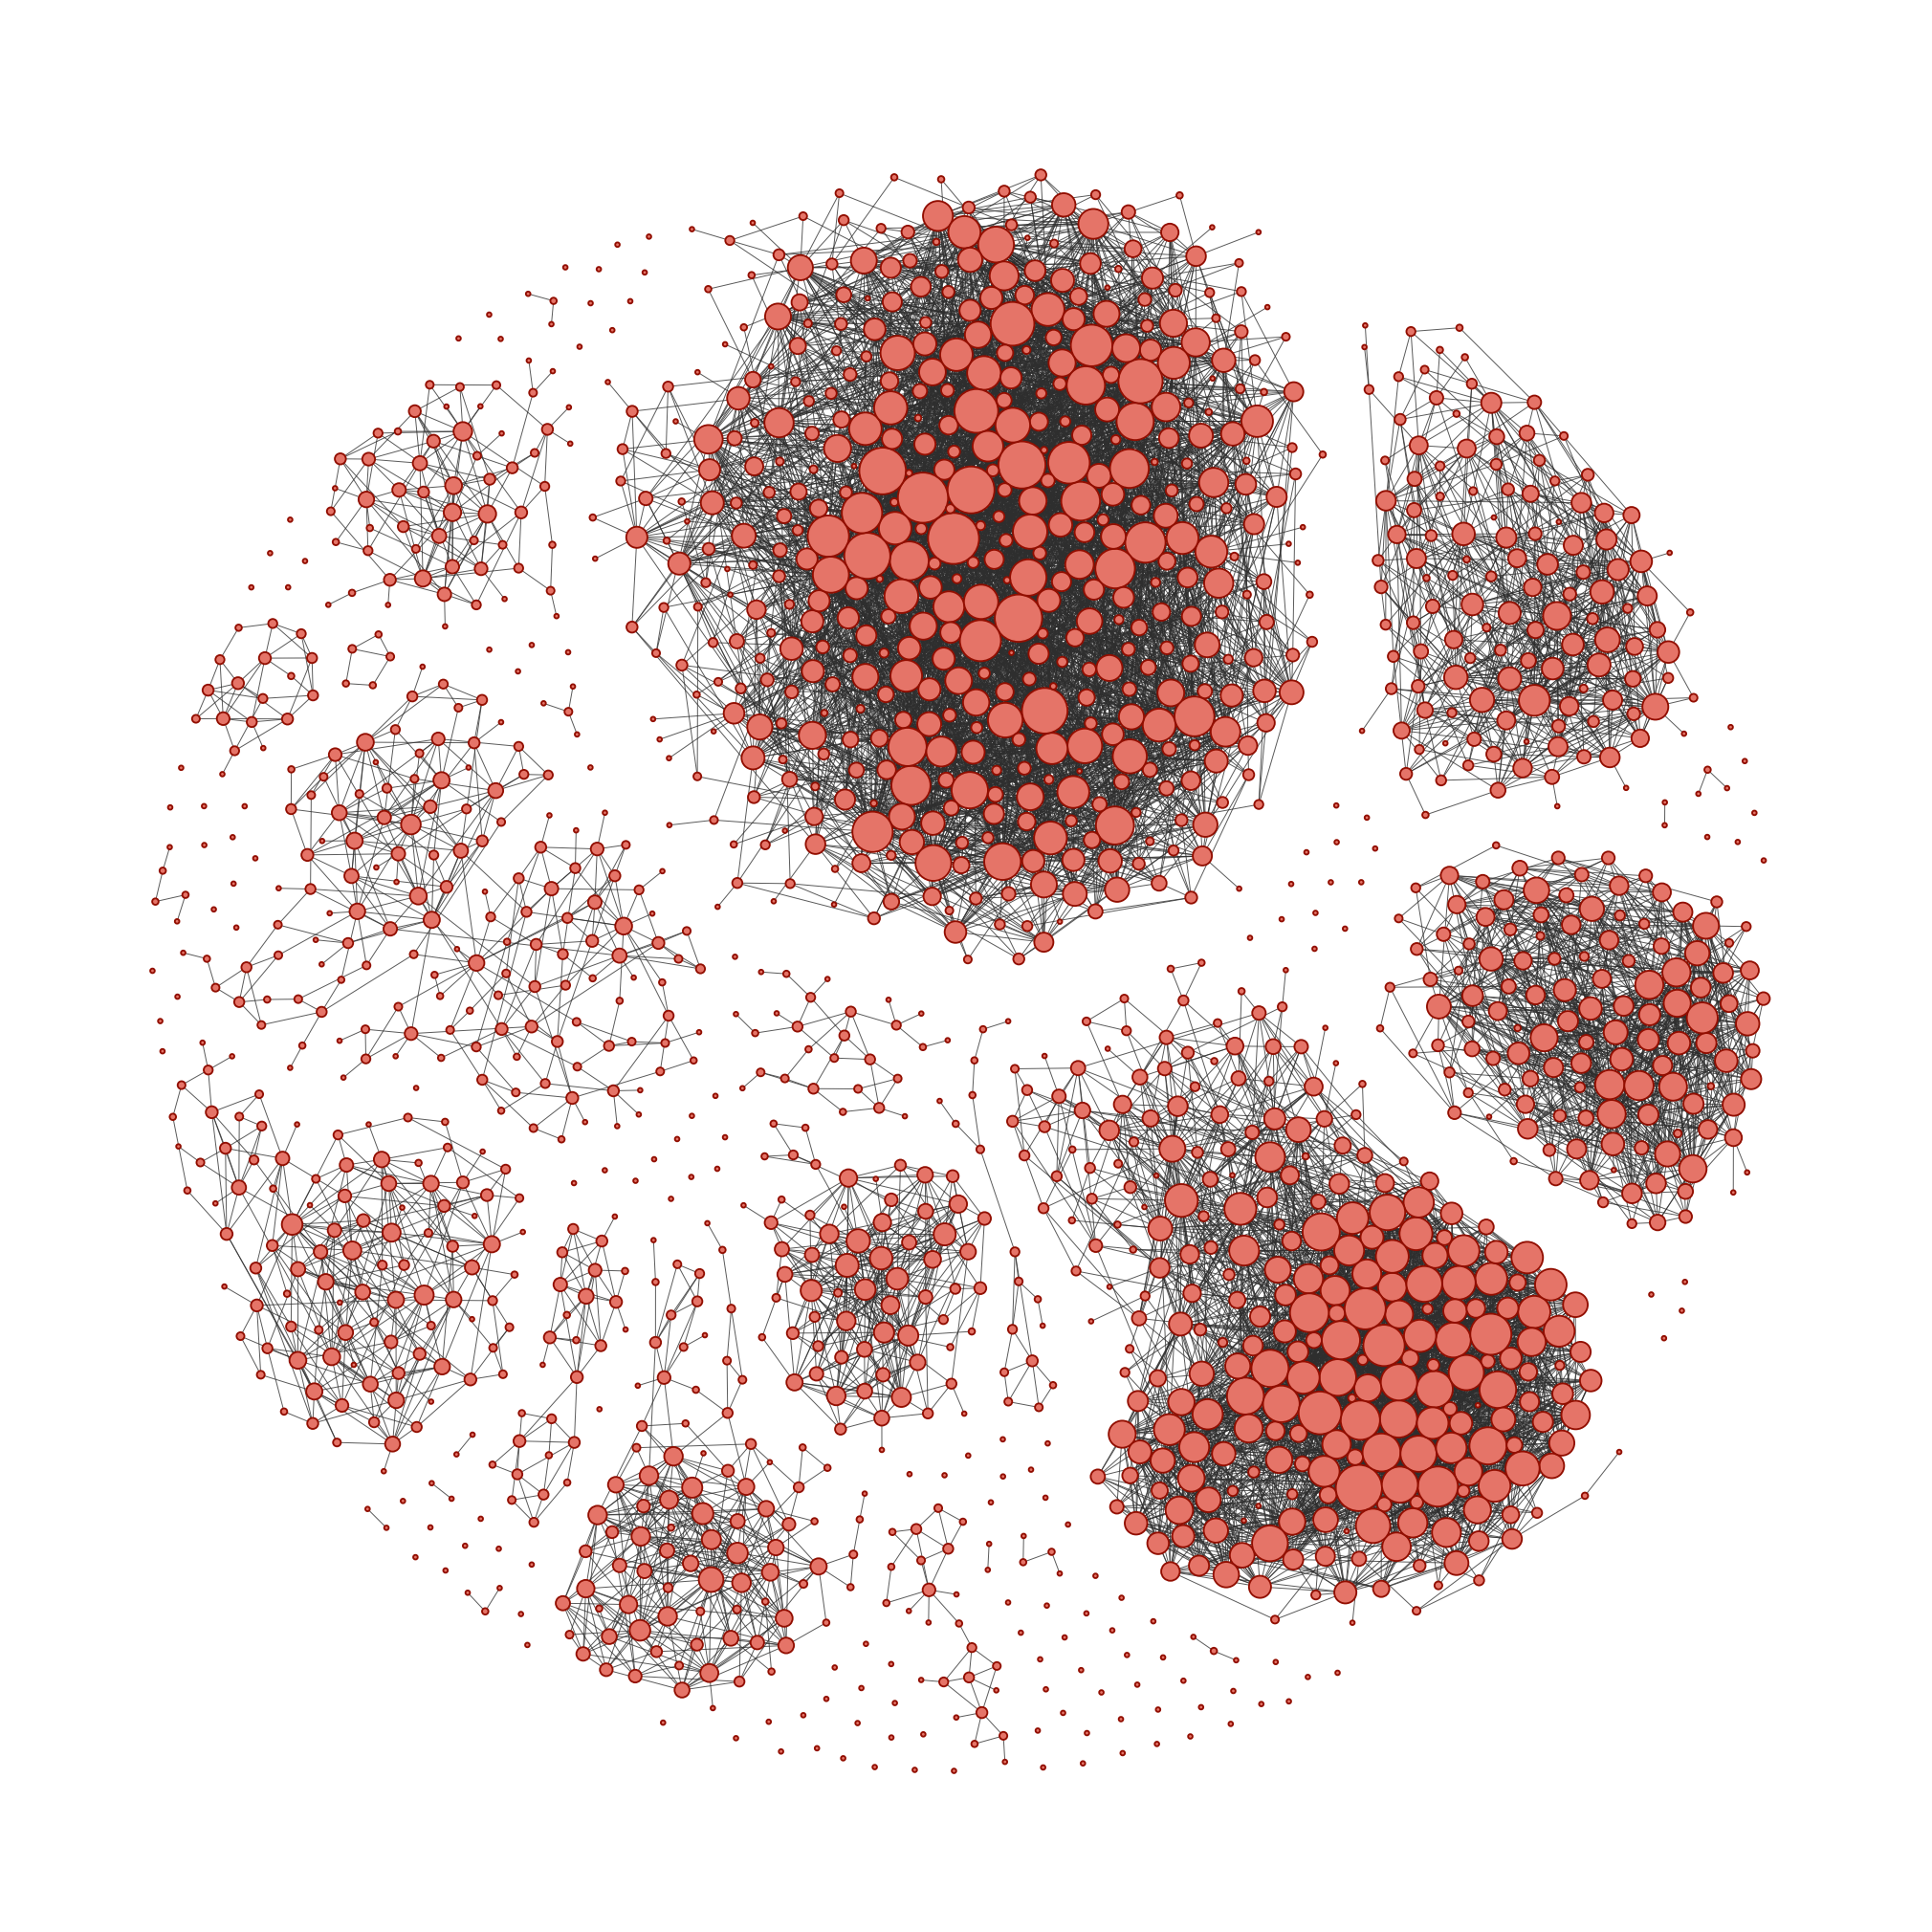

In [12]:
def netwulf_plot_(G, path="Network.pdf"):
    config_random_network = {
        # Input/output
        'zoom': 0.77,
        # Physics
        'node_charge': -58,
        'node_gravity': 0.85,
        'link_distance': 15,
        'link_distance_variation': 0,
        'node_collision': True,
        'wiggle_nodes': False,
        'freeze_nodes': False,
        # Nodes
        'node_fill_color': '#e57468',
        'node_stroke_color': '#920e00',
        'node_label_color': '#000000',
        'display_node_labels': False,
        'scale_node_size_by_strength': True,
        'node_size': 13.8,
        'node_stroke_width': 1,
        'node_size_variation': 0.5,
        # Links
        'link_color': '#2e2e2e',
        'link_width': 0.3,
        'link_alpha': 0.79,
        'link_width_variation': 0.5,
        # Thresholding
        'display_singleton_nodes': True,
        'min_link_weight_percentile': 0,
        'max_link_weight_percentile': 1
    }

    network, config = nw.visualize(G, plot_in_cell_below=False, config=config_random_network)

    fig, ax = nw.draw_netwulf(network, figsize=20)
    plt.savefig(path)

netwulf_plot_(G_rap_splittet)

## Fetch text data

In [13]:
combined_df = pd.concat([pop_df, rap_df])
artists_df = combined_df[['spotify_id', 'name']].drop_duplicates()

artists_df['representative_text'] = ''

artists_df = artists_df.reset_index(drop=True)

print(f"Total count of unique pop and rap artists: {len(artists_df)}")
artists_df.head()

Total count of unique pop and rap artists: 5404


,spotify_id,name,representative_text
0,4Lm0pUvmisUHMdoky5ch2I,Apocalyptica,
1,6M2wZ9GZgrQXHCFfjv46we,Dua Lipa,
2,0SIXZXJCAhNU8sxK0qm7hn,Stefanie Sun,
3,7jXoGtR69J2iYCefc58MZX,Twins,
4,2sjnyyL9NXijL3Fr2eLikf,Aspova,


In [29]:
import lyricsgenius
import concurrent.futures
import time
import csv

genius = lyricsgenius.Genius("SQ5PQucPjwa_LEDaobBQyxewdh80ZB-KhaBau73yASMRNIvnijWprQSi6ZDnUb7N", timeout=10, retries=3, remove_section_headers=True)
test_artists = artists_df["name"].tolist()

In [8]:
def fetch_top3(name): 
    try: 
        artist = genius.search_artist(name, max_songs=3, sort="popularity")
        if artist: 
            lyrics = []
            for song in artist.songs:
                lyr = (song.lyrics).split("Lyrics")[1]
                lyrics.append(lyr)
            
            return {"Artist": name ,"Lyrics": lyrics}
        
    except Exception as e:
        print(f"Error fetching song by {name}: {e}")
        return None 

In [ ]:
for i in range(0,len(test_artists),4): 
    batch = test_artists[i: i+4]
    rows = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        future_to_song = {executor.submit(fetch_top3, artist): artist for artist in batch}
        for future in concurrent.futures.as_completed(future_to_song):
            result = future.result()
            if result:
                rows.append(result)
    #for name in batch: 
    #    rows.append(fetch_top3(name))
    
     # Append to file
    with open("Artist_text.csv", mode="a", encoding="utf-8", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["Artist", "Lyrics"])
        writer.writerows(rows)

Searching for songs by Juice...
Searching for songs by Yomi...


Searching for songs by Ray Dalton...

Searching for songs by Kiana Ledé...

Changing artist name to 'YOMi'
Changing artist name to 'Juice WRLD'
Song 1: "Unnskyld"
Song 1: "EX"
Song 2: "I Choose You"
Song 2: "Kom nærmere"
Song 3: "Fairplay"

Reached user-specified song limit (3).
Done. Found 3 songs.
Song 3: "Erfaring"

Reached user-specified song limit (3).
Done. Found 3 songs.
Song 1: "Lucid Dreams"
Song 1: "Manila"
Song 2: "In My Bones"
Song 2: "All Girls Are the Same"
Song 3: "ALL WE GOT"

Reached user-specified song limit (3).
Done. Found 3 songs.
Song 3: "Wishing Well"

Reached user-specified song limit (3).
Done. Found 3 songs.
Searching for songs by Phoebe Ryan...

Searching for songs by MKTO...

Searching for songs by Joe Stone...

Searching for songs by Agnes...

Changing artist name to 'AGNEZ MO'
Song 1: "Damn I Love You"
Song 1: "Classic"
Song 1: "Is It Really Love"
Song 2: "Karena Ku Sanggup"
Song 2: "American

: 

: 

In [114]:
rows

[{'Artist': 'Yomi',
  'Lyrics': ["\n\nJeg skulle hørt på deg først\nOg ikke på meg selv\nOg ikke på meg selv\nMen om det er til no' trøst\nSå er ingenting bestemt\nJa, ingenting er bestemt\nVet du føler at jeg svikta deg (Svikta deg)\nNår alt jeg prøvde var å vise vei (Vise vei)\nMen jeg tror jeg leste skiltet feil\n\nSå la meg bare si unnskyld, okei?\nHører du meg?\nHører du meg?\nHører du meg?\nJa, det er bare min skyld, okei?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\n\nDu skulle sett deg selv\nSånn jeg så deg først, sånn jeg så deg først\nDu så ut som en drøm\nHenda som en bønn\nMynter i en brønn\n\nSå la meg bare si unnskyld, okei?\nHører du meg?\nHører du meg?\nHører du meg?\nJa, det er bare min skyld, okei?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\nHører du meg?\n\nDet va’kke dagen min\n(Det va'kke dagen min\nDet va'kke dagen min)\nDet va’kke dagen min\n

In [137]:
df_tes = pd.read_csv("Artist_text.csv")
df_tes["Lyrics"] = df_tes["Lyrics"].apply(ast.literal_eval)